# Vision Computacional - Tarea 2

- **Profesor**: Takeshi Asahi K.
- **Estudiante**: Matthias Clein E. 

## Cambio de dataset

En la Tarea 1 se seleccionó el dataset *"Car License Plate Detection"* extraído desde la plataforma Kaggle (https://www.kaggle.com/datasets/andrewmvd/car-plate-detection) propiedad del usuario *Larxel*. Este contaba con imágenes de automóviles en las cuales se puede apreciar su placa patente desde distintos ángulos pero para la aplicación de este trabajo, estas imágenes no serán útiles pues los colores, tamaños y posiciones de las patentes hacen que la detección sea muy complicada de implementar pues la variabilidad es muy alta.
Ante esto se seleccionó otro dataset desde la plataforma Kaggle, llamado *"Indian vehicle license plate dataset"* del usuario *Sai Sirisha* (https://www.kaggle.com/datasets/saisirishan/indian-vehicle-dataset). Si bien este se conforma de imágenes de patentes de automóviles de la India, dichas placas son de color blanco y con caracteres negros, similares a las placas patentes de Chile, lo que genera que la detección dentro de una imagen binaria sea más sencilla, facilitando la implementación del algoritmo.

## Flujo de procesamiento

1.- Diseñar un flujo de procesamiento a nivel abstracto: adquisición de imágenes, pre-procesamiento, procesamiento de imágenes, cálculo de la medición, almacenamiento.

Se toma como referencia la siguiente imagen presentada en la Clase 5.\
![Flujo de procesamiento](./img/Procesamiento_Imagenes-flujo.svg)

- **Adquisición**: En el inicio de este proyecto las imágenes serán estáticas, extraídas desde bases de datos públicas o de adquisión propia, pues lo que se busca es realizar una prueba de concepto para la detección de patentes de vehículos. En un futuro, cuando el procedimiento esté bien definido y probado, se podría implementar con video en streaming, considerando que la idea original del proyecto es que este sistema funcione en la entrada de un condominio o lugar residencial, en la cual haya una cámara de seguridad enfocando directamente a los vehículos que quieran ingresar obteniendo una imagen en la que se distinga claramente su placa patente.

- **Preprocesamiento**: Actualmente el preprocesamiento consiste en reescalar las imágenes a un tamaño estándar que en este caso es de 512 x 512 pixeles, utilizando la función *resize* de OpenCV. Luego, la imagen resultado se transforma a escala de grises utilizando la función *cvtColor*, con el fin de ocupar sólo uno de los tres canales originales y disminuir el tiempo y costo de procesamiento. Posteriormente se binariza la imagen a partir de un umbral, utilizando la función *threshold*, lo que genera que la imagen sólo cuente con pixeles completamente blancos o negros para resaltar la presencia de la placa patente que para los casos de Chile e India (imágenes de dataset público) son de color blanco. 

- **Procesamientos**: En la etapa de procesamiento se detectan y dibujan todos los contornos de la imagen binaria obtenida en el preprocesamiento. Esto se logra gracias a las funciones *findContours* y *drawContours* de OpenCV. También se calcula el área del contorno a través de la función *contourArea*. Luego, cada uno de los contornos es comparado con un rectángulo y en caso de tener 4 esquinas y poseer un área sobre un umbral se almacenan esos valores para recortar la zona de interés de la imagen, que es donde debiera estar ubicada la placa patente del vehículo. Finalmente se aplica un filtro a través de un kernel de convolución, utilizando la función *filter2D* para enfocar la patente, resaltando y detallando los bordes de la patente y los caracteres en su interior para que el proceso de OCR (Optical Character Recognition) tenga resultados más exactos.

- **Resultado**: En esta etapa ya se tiene una porción de la imagen original que consiste únicamente en la patente del vehículo. A través de la librería *pytesseract* se convierte esta imagen a un texto, considerando sólo letras y números (lo cual es configurado a través de una expresión regular). El string resultante de la función *image_to_string* será el contenido de la placa patente del automóvil que aparece en la imagen.

## Sistema de reconocimiento y/o procesamiento

2.- Realice una medida o inferencia sobre la imagen. Puede ser la detección de un objeto, medición de distancias entre píxeles de alguna característica, medición del tamaño de algún objeto (en cantidad de píxeles) clasificación de la imagen, entre otros.

Como se mencionó en el punto anterior, la etapa de procesamiento está enfocada en detectar y dibujar todos los contornos que posee la imagen binaria obtenida en la etapa de preprocesamiento para analizarlos y encontrar el rectángulo que corresponde a la placa patente del vehículo.

El procedimiento consiste en iterar sobre todos los contornos almacenados en la lista *contours*, y para cada uno de ellos:
- Obtener las coordenadas del rectángulo que puede encerrarlo a través de la función *boundingRect*.
- Calcular la relación de aspecto del rectángulo, lo que será utilizado posteriormente para comprobar si efectivamente puede ser una patente.
- Calcular el área del contorno a través de la función *contourArea*, lo que será utilizado posteriormente para comprobar si efectivamente tiene el tamaño de una patente. Además esto servirá para eliminar contornos pequeños.
- Aproximar el contorno con un polígono que tenga menos vértices a través de la función *approxPolyDP*, con el fin de reconocer si tiene 4 vértices para ser considerado un rectángulo.
- Luego se filtra por las condiciones de tener 4 vértices, que la relación de aspecto sea entre 2 y 7 u que el área del contorno sea mayor a 2000 pixeles. Si esto se cumple, el contorno es almacenado como una potencial patente. 

Luego de este proceso, se recorta la imagen en los pixeles obtenidos en el contorno para finalmente aplicar un filtro a través de un kernel de convolución, utilizando la función *filter2D* para realizar un enfoque (sharpening) a la placa patente, resaltando y detallando sus bordes y los caracteres en su interior para que el proceso de OCR (Optical Character Recognition) tenga resultados más precisos.

Importamos las librerías para manipulación de imágenes, arreglos, gráficas, OCR y expresiones regulares.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
import re

Luego ejecutamos el flujo de procesamiento detallado anteriormente sobre una imagen de prueba. Cada uno de los pasos es graficado dentro de una figura con varios ejes, que se puede apreciar a la salida de la siguiente celda. El procesamiento completo se encapsula en la función *plate_detection_image_processing*.

In [2]:
def plate_detection_image_processing(path):
    fig, ax = plt.subplots(4, 2, figsize = (8, 10))

    # Preprocesamiento - Imagen original reescalada a 512x512
    image = cv2.imread(path)
    image = cv2.resize(image, (512, 512))
    ax[0][0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Preprocesamiento - Imagen a escala de grises
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ax[0][1].imshow(image_gray, cmap = "gray")

    # Preprocesamiento - Imagen a binario
    image_binary = cv2.threshold(image_gray, 127, 255, cv2.THRESH_BINARY_INV)[1]
    ax[1][0].imshow(image_binary, cmap = "gray")

    # Procesamiento - Obtención de contornos dentro la imagen
    contours = cv2.findContours(image_binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
    background = np.zeros_like(image)
    cv2.drawContours(background, contours, -1, (0, 255, 0), 2)
    ax[1][1].imshow(background)

    # Procesamiento - Análisis de los contornos para reconocimiento de patente
    posibles_patentes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h
        area = cv2.contourArea(contour)
        approx = cv2.approxPolyDP(contour, 0.04 * cv2.arcLength(contour, True), True)
        if len(approx) == 4 and aspect_ratio > 2 and aspect_ratio < 7 and area > 2000:
            posibles_patentes.append(contour)
    background = np.zeros_like(image)
    cv2.drawContours(background, posibles_patentes, -1, (0, 255, 0), 2)
    ax[2][0].imshow(background)

    # Procesamiento - Posición de la patente dentro de la imagen
    cv2.drawContours(image, posibles_patentes, -1, (0, 255, 0), 2)
    ax[2][1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Procesamiento - Recorte de la patente reconocida
    patente = posibles_patentes[0]
    x, y, w, h = cv2.boundingRect(patente)
    recorte_patente = image[y:y+h, x:x+w]
    ax[3][0].imshow(recorte_patente)

    # Procesamiento - Patente con filtro para enfoque (sharpening)
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    patente_enfocada = cv2.filter2D(recorte_patente, -1, kernel)
    ax[3][1].imshow(patente_enfocada)
    plt.show()

    return patente_enfocada

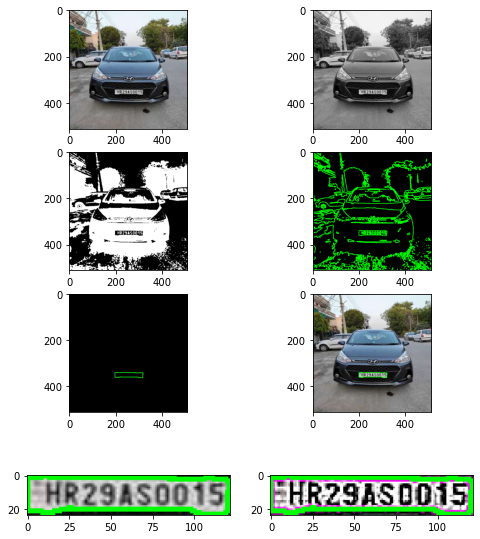

In [3]:
resultado = plate_detection_image_processing("./data/states/HR/HR9.jpg")

Con la imagen de la placa patente ya procesada, esta se ingresa a la función *image_to_string* de *Pytesseract* para obtener un string a partir de la imagen. El string resultante a su vez es formateado a partir de una expresión regular a partir de la cual se reemplazarán todos los caracteres que no sean letras o números por un espacio en blanco. Con esto podemos asegurar que el resultado no contendrá caracteres erróneos y sólo dependerá del modelo de OCR que se utilice.

In [4]:
# Resultado - Aplicación de OCR utilizando Pytesseract
text = pytesseract.image_to_string(cv2.cvtColor(resultado, cv2.COLOR_BGR2RGB), config = "--psm 10")
text= re.sub('[^a-zA-Z0-9]', '', text)
print(text)

HR29AS0015


## Tiempo de procesamiento

3.- Para procesar el conjunto completo de imágenes, medir los tiempos de ejecución del proceso completo. Realizar la medición para el 50% y el 100% de la imágenes varias veces, de manera de obtener algunas figuras estadísticas: tiempo máximo, tiempo mínimo, tiempo medio, desviación estándar del tiempo.

Importamos las librerías de manejo de sistema y de cronómetro de código.

In [5]:
import os
import timeit

Definimos el path de las imágenes que usaremos en el procesamiento.

In [6]:
images_path = './data/all_images/'
print(f"El dataset contiene {len(os.listdir(images_path))} imágenes.")

El dataset contiene 603 imágenes.


Definimos una función que realizará todo el procesamiento. Como parámetro se puede entregar un valor booleano para indicar si se quiere usar el dataset completo o sólo la mitad.

In [7]:
def plate_detection_time_test(images_path, half_data = False):
    images = sorted(os.listdir(images_path))

    if half_data:
        images = images[:len(images)//2]

    for car_image in images:
        if car_image.endswith(".jpg"):
            full_path = images_path + car_image

            # Preprocesamiento - Imagen original reescalada a 512x512
            image = cv2.imread(full_path)
            image = cv2.resize(image, (512, 512))

            # Preprocesamiento - Imagen a escala de grises
            image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Preprocesamiento - Imagen a binario
            image_binary = cv2.threshold(image_gray, 127, 255, cv2.THRESH_BINARY_INV)[1]

            # Procesamiento - Obtención de contornos dentro la imagen
            contours = cv2.findContours(image_binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
            background = np.zeros_like(image)
            cv2.drawContours(background, contours, -1, (0, 255, 0), 2)

            # Procesamiento - Análisis de los contornos para reconocimiento de patente
            posibles_patentes = []
            for contour in contours:
                x, y, w, h = cv2.boundingRect(contour)
                aspect_ratio = float(w) / h
                area = cv2.contourArea(contour)
                approx = cv2.approxPolyDP(contour, 0.04 * cv2.arcLength(contour, True), True)
                if len(approx) == 4 and aspect_ratio > 2 and aspect_ratio < 7 and area > 2000:
                    posibles_patentes.append(contour)
            background = np.zeros_like(image)
            cv2.drawContours(background, posibles_patentes, -1, (0, 255, 0), 2)

            # Procesamiento - Posición de la patente dentro de la imagen
            cv2.drawContours(image, posibles_patentes, -1, (0, 255, 0), 2)
          
            try:
                # Procesamiento - Recorte de la patente reconocida
                patente = posibles_patentes[0]
                x, y, w, h = cv2.boundingRect(patente)
                recorte_patente = image[y:y+h, x:x+w]

                # Procesamiento - Patente con filtro para enfoque (sharpening)
                kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
                patente_enfocada = cv2.filter2D(recorte_patente, -1, kernel)
            except:
                pass
            plt.show()

[FULL] - Tiempo de ejecución intento 1: 5.08[s]
[FULL] - Tiempo de ejecución intento 2: 4.29[s]
[FULL] - Tiempo de ejecución intento 3: 4.61[s]
[FULL] - Tiempo de ejecución intento 4: 4.94[s]
[FULL] - Tiempo de ejecución intento 5: 4.39[s]
[FULL] - Tiempo de ejecución intento 6: 4.52[s]
[FULL] - Tiempo de ejecución intento 7: 4.22[s]
[FULL] - Tiempo de ejecución intento 8: 4.2[s]
[FULL] - Tiempo de ejecución intento 9: 4.17[s]
[FULL] - Tiempo de ejecución intento 10: 4.25[s]
[HALF] - Tiempo de ejecución intento 1: 2.24[s]
[HALF] - Tiempo de ejecución intento 2: 2.08[s]
[HALF] - Tiempo de ejecución intento 3: 2.07[s]
[HALF] - Tiempo de ejecución intento 4: 2.1[s]
[HALF] - Tiempo de ejecución intento 5: 2.08[s]
[HALF] - Tiempo de ejecución intento 6: 2.06[s]
[HALF] - Tiempo de ejecución intento 7: 2.08[s]
[HALF] - Tiempo de ejecución intento 8: 2.07[s]
[HALF] - Tiempo de ejecución intento 9: 2.27[s]
[HALF] - Tiempo de ejecución intento 10: 2.07[s]


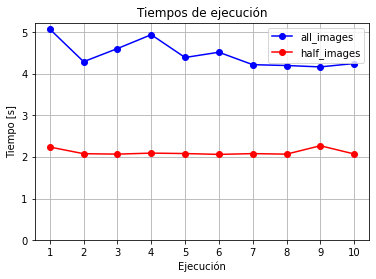

In [8]:
execution_times_full = timeit.repeat(lambda: plate_detection_time_test(images_path), number = 1, repeat = 10)
for i, time in enumerate(execution_times_full):
    print(f"[FULL] - Tiempo de ejecución intento {i + 1}: {round(time, 2)}[s]")

execution_times_half = timeit.repeat(lambda: plate_detection_time_test(images_path, half_data = True), number = 1, repeat = 10)
for i, time in enumerate(execution_times_half):
    print(f"[HALF] - Tiempo de ejecución intento {i + 1}: {round(time, 2)}[s]")

plt.plot(range(1, 11), execution_times_full, marker='o', linestyle='-', color='b', label = 'all_images')
plt.plot(range(1, 11), execution_times_half, marker='o', linestyle='-', color='r', label = 'half_images')
plt.xlabel('Ejecución')
plt.ylabel('Tiempo [s]')
plt.title('Tiempos de ejecución')
plt.grid(True)
plt.xticks(range(1, 11))
plt.yticks(range(0, 6))
plt.legend()
plt.show()

Tiempos de procesamiento (Sólo procesamiento)

Dataset completo:
- Tiempo mínimo: 4.17 [s]
- Tiempo máximo: 5.08 [s]
- Tiempo promedio: 4.47 [s]
- Desviación estándar: 0.32 [s]

Medio dataset:
- Tiempo mínimo: 2.06 [s]
- Tiempo máximo: 2.27 [s]
- Tiempo promedio: 2.11 [s]
- Desviación estándar: 0.07 [s]

In [9]:
def plate_detection_plot_time_test(images_path, half_data = False):
    images = sorted(os.listdir(images_path))

    if half_data:
        images = images[:len(images)//2]
    
    for car_image in images:
        if car_image.endswith(".jpg"):
            full_path = images_path + car_image

            fig, ax = plt.subplots(4, 2, figsize = (8, 10))

            # Preprocesamiento - Imagen original reescalada a 512x512
            image = cv2.imread(full_path)
            image = cv2.resize(image, (512, 512))
            ax[0][0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

            # Preprocesamiento - Imagen a escala de grises
            image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            ax[0][1].imshow(image_gray, cmap = "gray")

            # Preprocesamiento - Imagen a binario
            image_binary = cv2.threshold(image_gray, 127, 255, cv2.THRESH_BINARY_INV)[1]
            ax[1][0].imshow(image_binary, cmap = "gray")

            # Procesamiento - Obtención de contornos dentro la imagen
            contours = cv2.findContours(image_binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
            background = np.zeros_like(image)
            cv2.drawContours(background, contours, -1, (0, 255, 0), 2)
            ax[1][1].imshow(background)

            # Procesamiento - Análisis de los contornos para reconocimiento de patente
            posibles_patentes = []
            for contour in contours:
                x, y, w, h = cv2.boundingRect(contour)
                aspect_ratio = float(w) / h
                area = cv2.contourArea(contour)
                approx = cv2.approxPolyDP(contour, 0.04 * cv2.arcLength(contour, True), True)
                if len(approx) == 4 and aspect_ratio > 2 and aspect_ratio < 7 and area > 2000:
                    posibles_patentes.append(contour)
            background = np.zeros_like(image)
            cv2.drawContours(background, posibles_patentes, -1, (0, 255, 0), 2)
            ax[2][0].imshow(background)

            # Procesamiento - Posición de la patente dentro de la imagen
            cv2.drawContours(image, posibles_patentes, -1, (0, 255, 0), 2)
            ax[2][1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
          
            try:
                # Procesamiento - Recorte de la patente reconocida
                patente = posibles_patentes[0]
                x, y, w, h = cv2.boundingRect(patente)
                recorte_patente = image[y:y+h, x:x+w]
                ax[3][0].imshow(recorte_patente)

                # Procesamiento - Patente con filtro para enfoque (sharpening)
                kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
                patente_enfocada = cv2.filter2D(recorte_patente, -1, kernel)
                ax[3][1].imshow(patente_enfocada)
            except:
                pass
            plt.close()

[FULL] - Tiempo de ejecución intento 1: 62.61[s]
[FULL] - Tiempo de ejecución intento 2: 69.3[s]
[FULL] - Tiempo de ejecución intento 3: 81.55[s]
[FULL] - Tiempo de ejecución intento 4: 88.72[s]
[FULL] - Tiempo de ejecución intento 5: 80.25[s]
[HALF] - Tiempo de ejecución intento 1: 46.87[s]
[HALF] - Tiempo de ejecución intento 2: 41.01[s]
[HALF] - Tiempo de ejecución intento 3: 39.98[s]
[HALF] - Tiempo de ejecución intento 4: 40.57[s]
[HALF] - Tiempo de ejecución intento 5: 39.74[s]


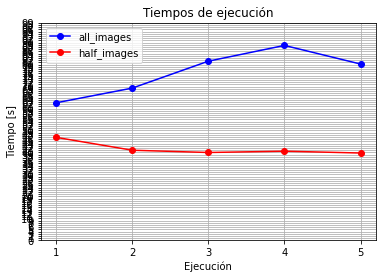

In [10]:
execution_times_plot_full = timeit.repeat(lambda: plate_detection_plot_time_test(images_path), number = 1, repeat = 5)
for i, time in enumerate(execution_times_plot_full):
    print(f"[FULL] - Tiempo de ejecución intento {i + 1}: {round(time, 2)}[s]")

execution_times_plot_half = timeit.repeat(lambda: plate_detection_plot_time_test(images_path, half_data = True), number = 1, repeat = 5)
for i, time in enumerate(execution_times_plot_half):
    print(f"[HALF] - Tiempo de ejecución intento {i + 1}: {round(time, 2)}[s]")

plt.plot(range(1, 6), execution_times_plot_full, marker='o', linestyle='-', color='b', label = 'all_images')
plt.plot(range(1, 6), execution_times_plot_half, marker='o', linestyle='-', color='r', label = 'half_images')
plt.xlabel('Ejecución')
plt.ylabel('Tiempo [s]')
plt.title('Tiempos de ejecución')
plt.grid(True)
plt.xticks(range(1, 6))
plt.yticks(range(0, 100))
plt.legend()
plt.show()

Tiempos de procesamiento (Procesamiento y gráficas)

Dataset completo:
- Tiempo mínimo: 62.61 [s]
- Tiempo máximo: 88.72 [s]
- Tiempo promedio: 76.49 [s]
- Desviación estándar: 10.41 [s]

Medio dataset:
- Tiempo mínimo: 39.74 [s]
- Tiempo máximo: 46.87 [s]
- Tiempo promedio: 41.63 [s]
- Desviación estándar: 2.97 [s]